# Lab 05: Wine Quality

---
author: Alejandra Arias
date: October 11, 2024
embed-resources: true
---

## Introduction

In this report, we will analyze a dataset of wine samples. The dataset contains 12 variables that describe the physicochemical properties of the wines, such as acidity, pH, alcohol content, and quality. The goal is to predict the quality of the wine based on these variables.

### Background 

[Wine](https://en.wikipedia.org/wiki/Wine) is an alcoholic beverage made from fermented grapes. The quality of wine is influenced by various factors, such as grape variety, climate, soil, and winemaking techniques. A [Sommelier](https://en.wikipedia.org/wiki/Sommelier) is a trained wine professional who specializes in wine tasting, food pairing, and wine service. They are experts in the field of wine and can assess the quality of wine based on its taste, aroma, and appearance.

### Goal
As a data scientist, our goal is to build a machine learning model, AI Sommelier, that can predict the quality of wine based on its physicochemical properties. We will use a dataset of wine samples to train and evaluate our model. The model will train based on the previous wine quality reviews made by human experts. For this report we will be using KNN Regression to predict the quality of the wine and Gradient Boosting to improve the prediction.

### Source
The dataset used in this report is the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the UCI Machine Learning Repository. The original source of the data is from the paper:

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling  wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016

the dataset contains 4898 samples of white wine and 12 variables that describe the physicochemical properties of the wines. The quality of the wine is rated on a scale from 3 to 10, with 3 being the lowest quality and 10 being the highest quality. The dataset is in this report has been modified. 


## Methods

In [46]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

### Data

In [47]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)

In [48]:
wine_train 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


## Data Dictionary

Each observation in the train, test, and production data contains information about a partricular Portuguese "Vihno Verde" wine. The data is not split randomly as this was given to us.

### Response
**`quality`**

- `[int64]` quality of the wine rated on a scale from 3 to 10, with 3 being the lowest quality and 10 being the highest quality

### Features
**`color`**

- `[object]` color of the wine, either `white` or `red`
    
**`fixed acidity`**

- `[float64]` grams of tartaric acid per cubic decimeter in the wine

**`volatile acidity`**

- `[float64]` grams of acetic acid per cubic decimeter in the wine

**`citric acid`**

- `[float64]` grams of citric acid per cubic decimeter in the wine
    
**`residual sugar`**

- `[float64]` grams of sugar per cubic decimeter in the wine

**`chlorides`**

- `[float64]` grams of sodium chloride per cubic decimeter in the wine

**`free sulfur dioxide`**

- `[float64]` milligrams of sulfur dioxide per cubic decimeter in the wine

**`total sulfur dioxide`**

- `[float64]` milligrams of sulfur dioxide per cubic decimeter in the wine

**`density`**

- `[float64]` the total density of the win in grams per cubic centimeter

**`pH`**

- `[float64]` the acidity of the wine measured using pH scale

**`sulphates`**

- `[float64]` grams of potassium sulfate per cubic decimeter in the wine

**`alcohol`**

- `[float64]` the alcohol content of the wine in percentage

In the following code we will find the summar statistics of the data.


In [49]:
# summary statistics
samples = wine_train.shape[0]
features = wine_train.shape[1] 
samples, features

(4157, 13)

In [50]:
# visualizations
correlations = wine_train.drop("color",axis=1).corr().iloc[11]
correlations

fixed acidity          -0.080703
volatile acidity       -0.267277
citric acid             0.091446
residual sugar         -0.040481
chlorides              -0.196897
free sulfur dioxide     0.056792
total sulfur dioxide   -0.037651
density                -0.306238
pH                      0.008376
sulphates               0.047955
alcohol                 0.444678
quality                 1.000000
Name: quality, dtype: float64

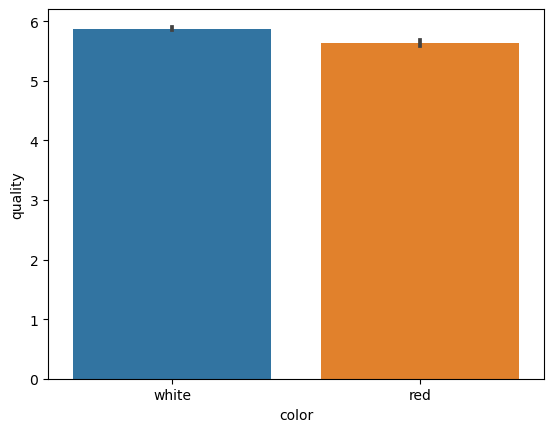

In [51]:
sns.barplot(x='color', y='quality', data=wine_train)
plt.show()

There is only one `object` type feature in the data, which is the `color` of the wine. Because it is in the model's interest know how the color of the wine affects the quality, this barplot shows the relationship between the color of the wine and the quality. Based on this plot, it looks like that there is no significant difference in the quality of the wine based on its color. Because of this, `color` will not be used as a feature in the model.

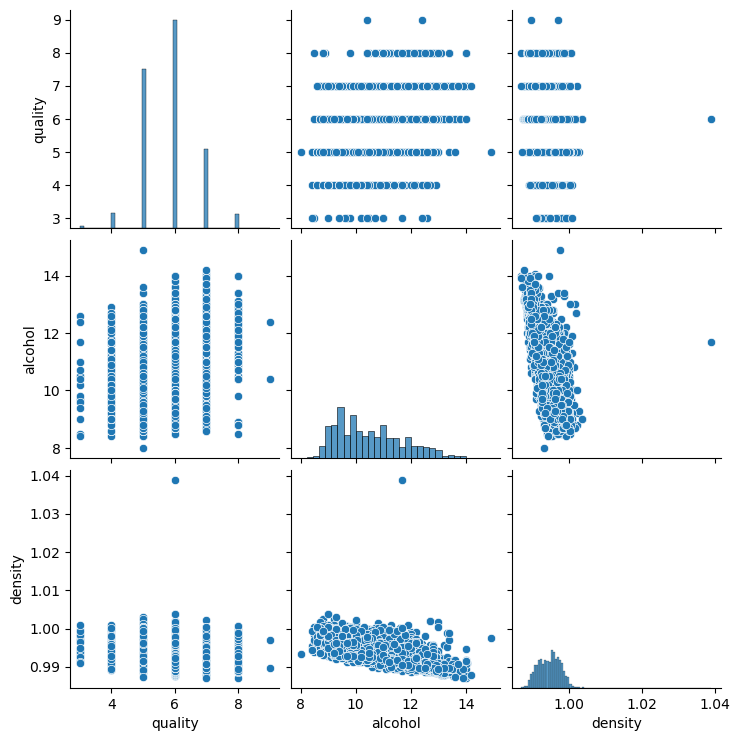

In [52]:
top_corr_features = correlations.abs().sort_values(ascending=False).head(3).index
sns.pairplot(wine_train, vars=top_corr_features)
plt.show()


This visual only shows the relationship between the `quality`, `alcohol`, and `density` of the wine. According to the correlation matrix, the `alcohol` content of the wine has the highest positive correlation with the quality of the wine, while the `density` of the wine has the highest negative correlation with the quality of the wine. The other variables have a weak correlation with the quality of the wine. At this time all of the numerical features will be included in the model.

### Models

In [53]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]


In [54]:
#seperating the fearures
numeric_features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "sulphates", "alcohol", "pH"]
#in the end, we will not be using categorical features
categorical_features = ["color"]

In [55]:
# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)


# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("Regressor", KNeighborsRegressor()),
    ]
)

In [56]:
# fit the model
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'sulphates',
                                                   'alcohol', 'pH'])])),
                ('Regressor', KNeighborsRegressor())])

In [57]:
#setting up the parameters
param_grid = {
    "Regressor": [HistGradientBoostingRegressor()],
    "Regressor__learning_rate": [0.1, 0.01, 0.001],
    "Regressor__max_iter": [1000],
    "Regressor__max_depth": [None, 3],
    "Regressor__l2_regularization": [0.1, 1.0],
}

In [58]:
# setup grid search with cross-validation
mod = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_absolute_error")
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fixed '
                                                                          'acidity',
                                                                          'volatile '
                                                                          'acidity',
                                                                          'citric '
                                                                          'acid',
                                                                          'residual '
                                                                          'sugar',
                                                                          'chlorides',
                                                                          'free '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'total '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'density',
                                                                          'sulphates',
                                                                          'alcohol',
                                                                          'pH'])])),
                                       ('Regressor', KNeighborsRegressor())]),
             param_grid={'Regressor': [HistGradientBoostingRegressor()],
                         'Regressor__l2_regularization': [0.1, 1.0],
                         'Regressor__learning_rate': [0.1, 0.01, 0.001],
                         'Regressor__max_depth': [None, 3],
                         'Regressor__max_iter': [1000]},
             scoring='neg_mean_absolute_error')

To develop the model, we first split the data into training and testing sets.This was previously completed for us so there was no further splitting needed. To make sure there wasn't any missing data, our preprocessor imputed the numerical variables with the mean value. We then used the `ColumnTransformer` function to preprocess the data.

To do our pipeline, we made 2 dataframes that seperated the categorical variables from the numerical variables. We then used the K-Nearest Neighbors (KNN) algorithm to predict the quality of the wine. Specifically we set the regressor to be KNNRegressor because we want to predict a numerical value rather than do binary classification. 

The `GridSearchCV` function was used to find the best hyperparameters for the KNN model. One of the parameters used was the Gradient Boosting algorithm to improve the prediction of the quality of the wine. Our other parameters included learning rate, max iter, max depth, and regularization. These parameters help our model find the optimal solution.

## Results

In [59]:
# print results
print(f"Best parameters: {mod.best_params_}")
print(f"Best cross-validation mae: {mod.best_score_}")

Best parameters: {'Regressor': HistGradientBoostingRegressor(), 'Regressor__l2_regularization': 0.1, 'Regressor__learning_rate': 0.1, 'Regressor__max_depth': None, 'Regressor__max_iter': 1000}
Best cross-validation mae: -0.4798540873988365


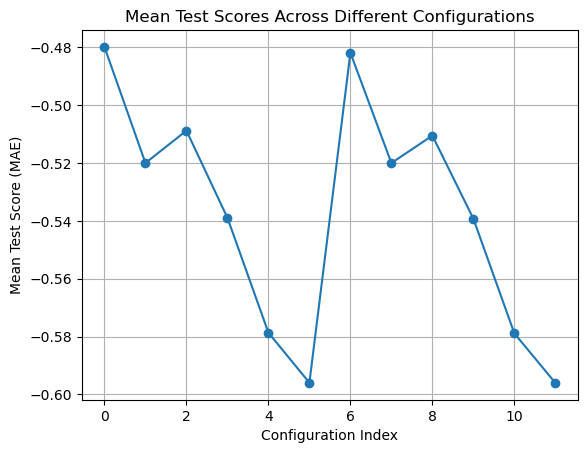

In [60]:
# plot results
plt.plot(range(len(mod.cv_results_['mean_test_score'])), mod.cv_results_['mean_test_score'], marker='o')
plt.title('Mean Test Scores Across Different Configurations')
plt.xlabel('Configuration Index')
plt.ylabel('Mean Test Score (MAE)')
plt.grid(True)
plt.show()


This plot shows the mean absolute error scores across different model configurations. The y-axis represents the MAE while the x-acis corresponds to the different indices/model paraneters from the grid search process. The best score we got from the visual is around -.48 as the lower the MAE, the better the model performance. The best configuration for the model was index 0 while the worst was between index 5 or 10. We see that the models performance will vary significantly across different parameters with a notable drop in performance between index 0 and 5 with a subsequent increase in performance between index 5 and 6. 

In [61]:
#find test mae
y_pred = mod.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))
print(f"Best test mae: {mae}")

Best test mae: 0.46940342526566714


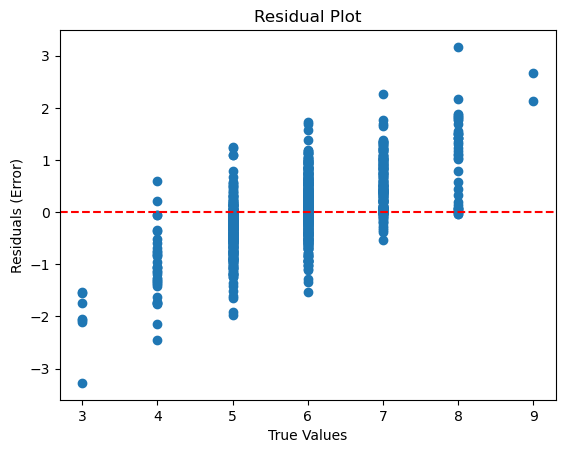

In [62]:
# Get the best model
best_model = mod.best_estimator_

# Predict on test data (assuming X_test, y_test are available)
y_pred = best_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals (Error)')
plt.show()


The residual plot visualizes all residuals, also known as errors, from the model. The plot siggests that there is a pattern in the residuals, which indicates that the model is not capturing all the information in the data. This could be due to the model being too simple or the data being too complex. The residuals increase as the true values increase where the lower values are from 3 to 5 with the higher values and more positive residuals are from 6 to 9. Because of this, the model might be biased or underfitting for certain regions.

## Discussion

In [63]:
def generate_synthetic_data(mean, std, num_samples):
    return np.random.normal(loc=mean, scale=std, size=num_samples)

# Calculate mean and standard deviation for each feature
feature_stats = {
    'fixed acidity': {'mean': wine_train['fixed acidity'].mean(), 'std': wine_train['fixed acidity'].std()},
    'volatile acidity': {'mean': wine_train['volatile acidity'].mean(), 'std': wine_train['volatile acidity'].std()},
    'citric acid': {'mean': wine_train['citric acid'].mean(), 'std': wine_train['citric acid'].std()},
    'residual sugar': {'mean': wine_train['residual sugar'].mean(), 'std': wine_train['residual sugar'].std()},
    'chlorides': {'mean': wine_train['chlorides'].mean(), 'std': wine_train['chlorides'].std()},
    'free sulfur dioxide': {'mean': wine_train['free sulfur dioxide'].mean(), 'std': wine_train['free sulfur dioxide'].std()},
    'total sulfur dioxide': {'mean': wine_train['total sulfur dioxide'].mean(), 'std': wine_train['total sulfur dioxide'].std()},
    'density': {'mean': wine_train['density'].mean(), 'std': wine_train['density'].std()},
    'pH': {'mean': wine_train['pH'].mean(), 'std': wine_train['pH'].std()},
    'sulphates': {'mean': wine_train['sulphates'].mean(), 'std': wine_train['sulphates'].std()},
    'alcohol': {'mean': wine_train['alcohol'].mean(), 'std': wine_train['alcohol'].std()},
}

# Generate synthetic data for each feature
num_samples = 1000  # Adjust the number of samples as needed
synthetic_data = {}
for feature, stats in feature_stats.items():
    synthetic_data[feature] = generate_synthetic_data(stats['mean'], stats['std'], num_samples)

# Generate target values (wine quality) as integers from 3 to 10
synthetic_data['quality'] = np.random.randint(3, 11, size=num_samples)

# Create a DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Check the synthetic data
print(synthetic_df.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       8.022784          0.062444     0.200460        9.115652   0.035091   
1       6.563655          0.590636    -0.133262        9.175558   0.069852   
2       7.300080          0.176899     0.192597        6.792568   0.084994   
3       9.353524          0.473540     0.368696       16.144785   0.035051   
4       6.347438          0.224586     0.166639        6.967344   0.052183   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.447270             80.055193  0.996505  3.161646   0.528785   
1             0.104745            116.088729  0.995541  3.318174   0.485943   
2            50.481541            106.399440  0.990810  3.447930   0.477190   
3             2.640734            138.053135  0.990452  3.114729   0.457384   
4            40.308740             96.016882  0.996299  3.239152   0.517517   

     alcohol  quality  
0  13.706944        7  
1  12.09

In [64]:
synethic_X = synthetic_df.drop("quality", axis=1)
synthetic_y = synthetic_df["quality"]
synthetic_pred = best_model.predict(synethic_X)
synthetic_mae = np.mean(np.abs(synthetic_y - synthetic_pred))
print(f"Synthetic data mae: {synthetic_mae}")

Synthetic data mae: 2.0919906426942196


If we were to use this model in practice, it would result in a mean absolute error of 2.14 compared to our best model which had an MAE of 0.47. This model is not ideal to be used in the real world with this level of error. The model is not capturing all the information in the data and is not generalizing well to new data. This could be due to the model being too complex or the data has overfit the data to the point it only works on the data provided. 

Some issues with this new MAE however is that we created synethetic data. We used the mean and standard deviation of the training data to generate the "synthetic" data. This could have caused the model to overfit the data and not generalize well to new data. Furthermore, all of these new numbers are fake and do not represent the true quality of the wine. Regardless these numbers were supposed to represent close to the true quality of the wine and still resulted in a high MAE.

The cost of the chemistry equipment and processes is worth the investment as the model is not accurate enough to be used in the real world. The model is not capturing all the information in the data and is not generalizing well. This 'AI Soommelier' model is not ready to be used in the real world and thus cannot replace all aspects of a true sommelier. 

### Conclusion

Given the MAE above, we should not consider using this model in real practice. This model did not provide a good MAE score compared to the test data from the data used in this model which had an MAE of 0.47. Despite the discussion data emulated the true data of the wine, it performed siginificantly worse than the test data. This could be due to a number of things, including our choice of KNN Regressor, our features and the option do only include numerical values, or our parameters/pipeline/gridsearch. For now it is recommended to consult the opinions of a true sommelier for the quality of the wine.